In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalMaxPool1D, Bidirectional, Convolution1D, Embedding, BatchNormalization,MaxPooling1D, Dropout, LSTM
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.models import Model
from keras.layers.merge import Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
INPUT_PATH = '../input/'
CACHE_PATH = '../cache/'
OUTPUT_PATH ='../output/'

In [3]:
data = np.load(CACHE_PATH + 'data.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
embedding_matrix = np.load(CACHE_PATH + 'embedding_matrix.npy')

In [4]:
MAX_FEATURES = 20000
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 300

In [5]:
embedding_layer = Embedding(MAX_FEATURES,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [6]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim

In [7]:
def get_attention_model1():
    inp = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(inp)
    x = Bidirectional(LSTM(256, dropout=0.25, recurrent_dropout=0.25, return_sequences=True))(embedded_sequences)
    merged = Attention(MAX_SEQUENCE_LENGTH)(x)
    merged = Dense(256, activation='relu')(merged)
    merged = Dropout(0.25)(merged)
    merged = BatchNormalization()(merged)
    preds = Dense(1, activation='linear')(merged)
    model = Model(inputs=inp, outputs=preds)
    model.compile(loss='mse',optimizer='adam')
    return model

In [25]:
def get_attention_model2():
    inp = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(inp)
    #Bidirectional LSTM  双向循环神经网络     
    x = Bidirectional(LSTM(100, dropout=0.25, recurrent_dropout=0.25, return_sequences=True))(embedded_sequences)
    merged = Attention(MAX_SEQUENCE_LENGTH)(x)
    merged = Dense(100, activation='relu')(merged)
    merged = Dropout(0.25)(merged)
    
#     merged = BatchNormalization()(merged)
    merged = Attention(MAX_SEQUENCE_LENGTH)(x)
    merged = Dense(50, activation='relu')(merged)
    merged = Dropout(0.25)(merged)
    
    merged = BatchNormalization()(merged)
    preds = Dense(1, activation='linear')(merged)
    model = Model(inputs=inp, outputs=preds)
    model.compile(loss='mse',optimizer='adam')
    return model

In [26]:
def train_attention_model(model):
    model_path = CACHE_PATH + "attention_weights_best.hdf5"
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint, early]
    model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_val, y_val), callbacks=callbacks_list)
    model.load_weights(model_path)
    return model

In [27]:
model = get_attention_model2()

In [28]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='Atttention.png')

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 300)          6000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300, 200)          320800    
_________________________________________________________________
attention_4 (Attention)      (None, 200)               500       
_________________________________________________________________
dense_5 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 50)                200       
__________

In [13]:
model = train_attention_model(model)

Train on 209000 samples, validate on 11000 samples
Epoch 1/100
209000/209000 [==============================] - 981s 5ms/step - loss: 1.8074 - val_loss: 0.6180

Epoch 00001: val_loss improved from inf to 0.61800, saving model to ../cache/attention_weights_best.hdf5
Epoch 2/100
209000/209000 [==============================] - 978s 5ms/step - loss: 0.4645 - val_loss: 0.4386

Epoch 00002: val_loss improved from 0.61800 to 0.43860, saving model to ../cache/attention_weights_best.hdf5
Epoch 3/100
209000/209000 [==============================] - 979s 5ms/step - loss: 0.4605 - val_loss: 0.8069

Epoch 00003: val_loss did not improve
Epoch 4/100
209000/209000 [==============================] - 979s 5ms/step - loss: 0.4486 - val_loss: 0.8221

Epoch 00004: val_loss did not improve
Epoch 5/100
209000/209000 [==============================] - 979s 5ms/step - loss: 0.4403 - val_loss: 1.2462

Epoch 00005: val_loss did not improve
Epoch 6/100
209000/209000 [==============================] - 979s 5ms/s

In [14]:
y_test = model.predict(X_test,batch_size=128,verbose=1)

50000/50000 [==============================] - 58s 1ms/step


In [18]:
def round_score(score):
    if score>5:
        score = 5
    if  score < 1:
        score= 1
    return score

In [19]:
sub = pd.read_csv(INPUT_PATH + 'sample.csv',header=None,names=['Id','Score'])
sub['Score'] = y_test

In [22]:
sub['Score'] = sub['Score'].map(round_score)

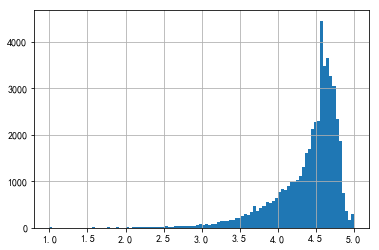

In [23]:
%matplotlib inline
sub['Score'].hist(bins = 100)

In [24]:
sub.to_csv(OUTPUT_PATH + 'attention_0404.csv',index=False, header=False)